In [1]:
import numpy as np
random_generator = np.random.default_rng()

def softmax(x):
    # Assumption - x is of shape NxK
    result = []
    for x_ in x:
        x_ = x_ - max(x_) # to prevent overflow in exponential
        result.append(np.exp(x_)/np.sum(np.exp(x_)))
    return np.array(result)


def one_hot(idx, num_classes):
    result = np.zeros(num_classes)
    result[idx] = 1
    return result

def acc(y_true, y_pred):
    tp = len([y_pred[i] for i in range(len(y_true)) if y_pred[i]==y_true[i]])
    return tp/len(y_true) 

def confusion(y_true, y_pred):
    K = len(np.unique(y_true))
    CM = np.zeros((K, K))
    for t, y in zip(y_true, y_pred):
        if t==y:
            CM[t, t] += 1
        else:
            CM[t, y] += 1
    return CM

In [2]:

class MidSem:
    def __init__(self):
        self.params = None

    def generateData(self, params):
        X_ki = []
        for param in params:
            # param is [mu, cov, N]
            mu, cov, N = param
            samples = random_generator.multivariate_normal(mu, cov, N)
            X_ki.append(samples)
        return X_ki

    def trainWithMSE(self, X_ki, Yd_k):
        """
        X_ki is of shape (K, N, M)
        Yd_k is of shape (2,)
        """
        # Generating the dataset
        X = []
        t = []
        for cluster, target in zip(X_ki, Yd_k):
            for x_ in cluster:
                X.append(np.array([*x_, 1]))
                t.append(target)
        X, T = np.array(X), np.array(t)[:, np.newaxis]

        # Setting the weights as per least mse solution
        w = (np.linalg.inv(X.T @ X) @ X.T) @ T

        return w

    def trainBP(self, X_ki, Nepochs=100, eta=0.001):
        pass
        steps_per_epoch = 10
        # Generating the dataset
        X = []
        t = []
        K = len(X_ki)
        for i, cluster in enumerate(X_ki):
            for x_ in cluster:
                X.append(np.array([*x_, 1]))
                t.append(one_hot(i, K))

        X, T = np.array(X), np.array(t)

        # Training the model
        w = np.random.rand(X.shape[1], len(X_ki))
        for epoch in range(1, Nepochs + 1):
            train_loss = np.inf

            for step in range(steps_per_epoch):
                pred = softmax(X @ w)
                dW = X.T @ (pred - t) # Gradient for Categorical Crossentropy
                w -= eta*dW 
        return w

    def evaluate(self, X_i, t_i, w):
        """
        Evaluates both binary and softmax-based classifiers
        CM - Confusion Matrix of shape (K,K) : K is the number of classes

        """
        K = max(2, w.shape[1]) 
        accuracy = 0
        CM = np.zeros((K, K))
        X_i = np.array([[*x, 1] for x in X_i])

        if w.shape[1] == 1:  # ie we're evaluating the least-mse model
            classes = np.unique(t_i)
            threshold = np.mean(classes)
            y_i = X_i @ w
            Y_i = []
            for y in y_i:
                if y >= threshold:
                    Y_i.append(max(classes))
                else:
                    Y_i.append(min(classes))
            Y_i = np.array(Y_i)
            accuracy = acc(Y_i, t_i)
            CM = confusion(Y_i, t_i)
        else:  # Eval for softmax-based multi-class classifier
            y_i = X_i @ w
            Y_i = []
            for pred in y_i:
                Y_i.append(np.argmax(pred))
            accuracy = acc(Y_i, t_i)
            CM = confusion(Y_i,t_i)
        return CM, accuracy, Y_i


# Test-runs


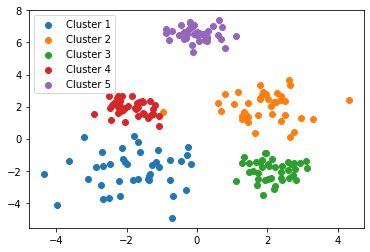

In [3]:
# Testing data generation
import matplotlib.pyplot as plt # only for plotting

gen_test = MidSem()
params = [
    [np.array([-2, -2]), np.eye(2), 40],
    [np.array([2, 2]), 0.5 * np.eye(2), 40],#,
    [np.array([2, -2]), 0.3 * np.eye(2), 40],
    [np.array([-2, 2]), 0.2 * np.eye(2), 40],
    [np.array([0, 6.5]), 0.2 * np.eye(2), 40]
]
sample_dat = gen_test.generateData(params)
for i, sam in enumerate(gen_test.generateData(params)):
    plt.scatter(sam[:, 0], sam[:, 1], label = f"Cluster {i+1}")
plt.legend()
plt.show()


In [4]:
# Testing binary classification with least square methods
bin_test = MidSem()
w = bin_test.trainWithMSE(sample_dat, [-1, 1])
print(w.shape)
print(w)

(3, 1)
[[ 0.23711542]
 [ 0.22052152]
 [-0.0085415 ]]


In [5]:
# Testing the softmax Model
soft_test = MidSem()
sample_dat_ = soft_test.generateData(params)
W = soft_test.trainBP(sample_dat, 5, 0.1)
print(W.shape)
print(W)

(3, 5)
[[-21.74374203  23.90067758  17.43621082 -18.99743601   1.95075962]
 [-17.83262157   4.69780124 -17.98989561  10.49980792  23.37898874]
 [  9.05124666   6.02672049  -5.02877567   4.67057695 -12.55819013]]


In [6]:
# Testing evaluations for the multi-class classifier (BP)
data = soft_test.generateData(params)
x_test = []
y_test = []
for i, x in enumerate(data):
    for sample in x:
        x_test.append(sample)
        y_test.append(i)
x_test, y_test = np.array(x_test), np.array(y_test)
print(x_test.shape, y_test.shape)

(200, 2) (200,)


Accuracy =  0.965


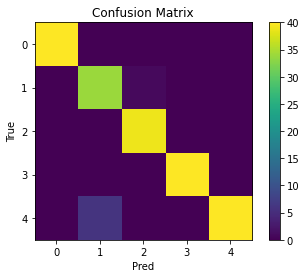

In [7]:
CM, accuracy, Y_i = soft_test.evaluate(x_test, y_test, W)
print("Accuracy = ", accuracy)
plt.imshow(CM)
plt.title("Confusion Matrix")
plt.colorbar()
plt.xlabel("Pred")
plt.ylabel("True")
plt.show()

[-21.74374203 -17.83262157   9.05124666]
[23.90067758  4.69780124  6.02672049]
[ 17.43621082 -17.98989561  -5.02877567]
[-18.99743601  10.49980792   4.67057695]
[  1.95075962  23.37898874 -12.55819013]


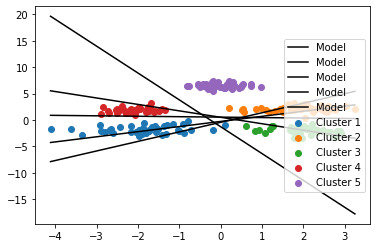

In [8]:
for w in W.T:
    print(w)
    a, b, c = w # ax+by+c = 0
    
    x = [min(x_test[:, 0]), max(x_test[:, 0])]
    y = [(-a*i-c)/b for i in x]
    plt.plot(x, y, label = "Model", c = 'black')

for i, sam in enumerate(data):
    plt.scatter(sam[:, 0], sam[:, 1], label = f"Cluster {i+1}")
plt.legend(loc = 'right')
plt.show()

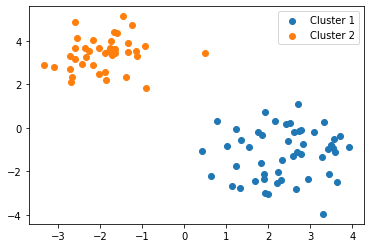

In [9]:
# Testing evaluations for the binary classifier
params = [
    [np.array([2.5, -1.3]), np.eye(2), 50],
    [np.array([-1.9, 3.4]), 0.5 * np.eye(2), 40],
]
test_data = gen_test.generateData(params)
for i, sam in enumerate(test_data):
    plt.scatter(sam[:, 0], sam[:, 1], label = f"Cluster {i+1}")
plt.legend()
plt.show()

In [10]:
x_test = []
y_test = []
for i, x in enumerate(test_data):
    for sample in x:
        x_test.append(sample)
        y_test.append(i)
x_test, y_test = np.array(x_test), np.array(y_test)
print(x_test.shape, y_test.shape)

(90, 2) (90,)


Accuracy =  0.9777777777777777


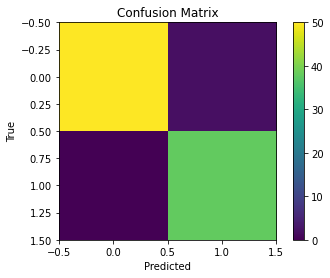

In [11]:
w = gen_test.trainWithMSE(gen_test.generateData(params), [-1, 1])
CM, Acc, Y_i = gen_test.evaluate(x_test, y_test, w)
print("Accuracy = ", Acc)
plt.imshow(CM)
plt.title("Confusion Matrix")
plt.ylabel("True")
plt.xlabel("Predicted")
plt.colorbar()
plt.show()

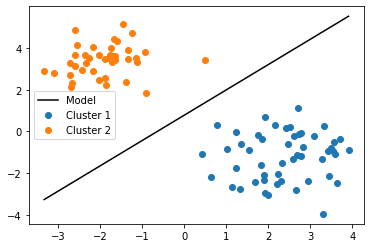

In [12]:
# Getting the line from the weights
a, b, c = w # ax+by+c = 0
x = [min(x_test[:, 0]), max(x_test[:, 0])]
y = [(-a*i-c)/b for i in x]

plt.plot(x, y, label = "Model", c = 'black')

for i, sam in enumerate(test_data):
    plt.scatter(sam[:, 0], sam[:, 1], label = f"Cluster {i+1}")
plt.legend()
plt.show()